In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/x96/*.npy .
!cp -r gdrive/My\ Drive/tools/ .
!cp -r gdrive/My\ Drive/models/ .
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 5994972
drwx------ 3 root root       4096 May  4 19:39 gdrive
drwx------ 3 root root       4096 May  4 19:41 models
drwxr-xr-x 1 root root       4096 Apr 29 16:32 sample_data
drwx------ 3 root root       4096 May  4 19:41 tools
-rw------- 1 root root  818509952 May  4 19:39 X_test.npy
-rw------- 1 root root 2619205760 May  4 19:40 X_train.npy
-rw------- 1 root root  654815360 May  4 19:40 X_val.npy
-rw------- 1 root root  409255040 May  4 19:40 y_test.n

In [ ]:
!cp gdrive/My\ Drive/12/weights5 weights

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import tools._my_tools as mt
import tools._torch_tools as tt
import models.loss as lo
import numpy as np

import gc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
empty = np.array([[[[0]]]])

ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
X_val, y_val = mt.loadData("",val=True,typeF='float16',channels_last=False)

Loading X_val.npy


In [ ]:
X_train, y_train = mt.loadData("",train=True,typeF='float16',channels_last=False)

Loading X_train.npy
Loading y_train.npy


In [ ]:
for i in range(10):
    print("----------------\n1\n----------------")
    a,b = mt.loadData("",val=True, typeF='float16')
    a = empty
    b = empty
    gc.collect()
    a,b = mt.loadData("",test=True, typeF='float16')
    a = empty
    b = empty
    gc.collect()

In [3]:
import gc
gc.collect()

0

In [ ]:
mt.loadData("",train=True,typeF='float16')

In [ ]:

a,b=[empty.copy(),empty.copy()]

In [ ]:
# import torchvision

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.activation = nn.PReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        
        self.conv32 = self._convBlock(2, 32, **self.conv_setup)
        self.conv64 = self._convBlock(32, 64, **self.conv_setup)
        self.conv128 = self._convBlock(64, 128, **self.conv_setup)
        self.conv256 = self._convBlock(128, 256, **self.conv_setup)
        self.conv256_256 = self._convBlock(256, 256, **self.conv_setup)


        self.upsample256 = self._upsampleBlock(self.upsample_layer, 256, 256, **self.conv_setup)
        self.deconv128 = self._convBlock(256, 128, **self.conv_setup)
        self.upsample128 = self._upsampleBlock(self.upsample_layer, 128, 128, **self.conv_setup)
        self.deconv64 = self._convBlock(128, 64, **self.conv_setup)
        self.upsample64 = self._upsampleBlock(self.upsample_layer, 64, 64, **self.conv_setup)
        self.deconv32 = self._convBlock(64, 32, **self.conv_setup)
        self.upsample32 = self._upsampleBlock(self.upsample_layer, 32, 32, **self.conv_setup)
        self.deconv1 = self._convBlock(32, 1, kernel=(3,3), stride=(1,1), padding=1, activation=None)
        
    def forward(self, x):
        x32 = self.conv32(x)
        x32_p = self.pooling_layer(x32)
        x64 = self.conv64(x32_p)
        x64_p = self.pooling_layer(x64)
        x128 = self.conv128(x64_p)
        x128_p = self.pooling_layer(x128)
        x256 = self.conv256(x128_p)
        x256_p = self.pooling_layer(x256)

        x = self.conv256_256(x256_p)

        # expansion

        x = self.upsample256(x)
        x += x256
        x = self.deconv128(x)

        x = self.upsample128(x)
        x += x128
        x = self.deconv64(x)

        x = self.upsample64(x)
        x += x64
        x = self.deconv32(x)
        
        x = self.upsample32(x)
        x += x32
        x = self.deconv1(x)
        
        return x
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding)
        )
        if activation is not None:
            net = nn.Sequential(
                net, 
                nn.BatchNorm2d(out_channels),
                activation
            )
        return net
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
#             nn.ConvTranspose2d(in_channels,in_channels,(2,2),(2,2)),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), nn.PReLU()
        )

# model = Model()#.to(device)
# # # model.to(device)
# if device == torch.device("cpu"):
#     print(summary(model, (2,96,96)))
# else:
#     print(summary(model.cuda(), (2,96,96)))

In [ ]:
model = Model()
model.load_state_dict(torch.load("weights"))
# loss = VggLoss()
# loss = CombinedLoss()
training = tt.Training(model, device, empty, empty)
a,b=[empty,empty]

In [19]:
n_epochs = 5
try:
    for e in range(n_epochs):
        print("="*40)
        print("In epoch",e)
        a,b = [empty,empty]
        gc.collect()
#         input("continue?")
        a,b = mt.loadData("",train=True,typeF='float16',channels_last=False)
#         input("continue?")
        training.setTrain(a,b)
#         input("continue?")
        training.fit(32,1)
        training.setTrain(empty,empty)
        a,b = [empty,empty]
        gc.collect()
#         input("continue?")
        print('\n')
        a,b = mt.loadData("",val=True,typeF='float16',channels_last=False)
        training.setVal(a,b)
        training.validate(32)
        training.setVal(empty,empty)
        a,b = [empty,empty]
        gc.collect()
except KeyboardInterrupt:
    print("\n\nFinished training.")

In epoch 0
Loading X_train.npy
Loading y_train.npy


====== TRAINING ======
===> Epoch[1](4440/4440): Loss: 0.0272	ETA 0:00:00	Epoch Loss: 0.0245
Epoch[1] finished in 0:10:38 with loss 0.02445221503542082

----------------------------

Finished training of 1 epochs in 0:10:38.


Loading X_val.npy
Loading y_val.npy
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0224
Validation loss = 0.0224
In epoch 1
Loading X_train.npy
Loading y_train.npy


====== TRAINING ======
===> Epoch[1](4440/4440): Loss: 0.0238	ETA 0:00:00	Epoch Loss: 0.0207
Epoch[1] finished in 0:10:38 with loss 0.020685395672665658

----------------------------

Finished training of 1 epochs in 0:10:38.


Loading X_val.npy
Loading y_val.npy
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0202
Validation loss = 0.0202
In epoch 2
Loading X_train.npy
Loading y_train.npy


====== TRAINING ======
===> Epoch[1](4440/4440): Loss: 0.0230	ETA 0:00:00	Ep

In [ ]:
!cp weights1 gdrive/My\ Drive/12/5_transpose/weights
mt.toCSV("tmp.csv",training.history)
!cp tmp.csv gdrive/My\ Drive/12/5_transpose/.

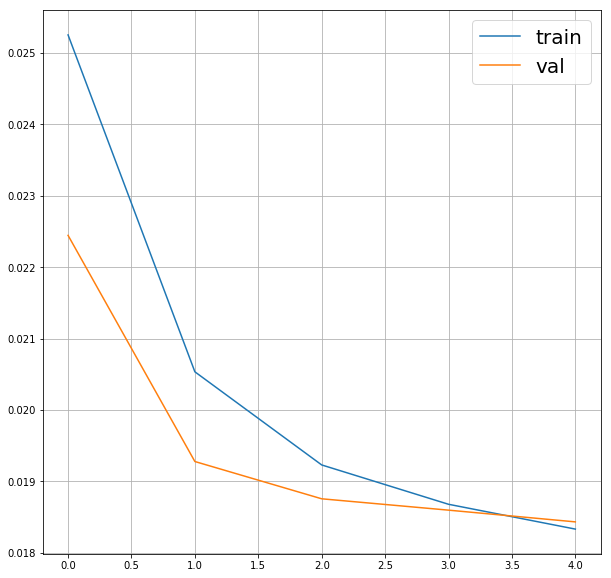

In [11]:
import matplotlib.pyplot as plt
def plotHistory(history, size=(10,10)) :
    plt.figure(figsize=size)
    plt.grid(True)

    for key, val in history.items():
        assert type(val) == list
        plt.plot(range(len(val)),val,label=key)
    plt.legend(loc='upper right', prop={'size': 20})
    plt.show()
plotHistory(training.history)

In [7]:
training.history

{'train': [0.029112232575043983, 0.025371613442930027],
 'val': [0.026031328574964055, 0.024229849866583004]}

Loading X_test.npy
Loading y_test.npy


22139

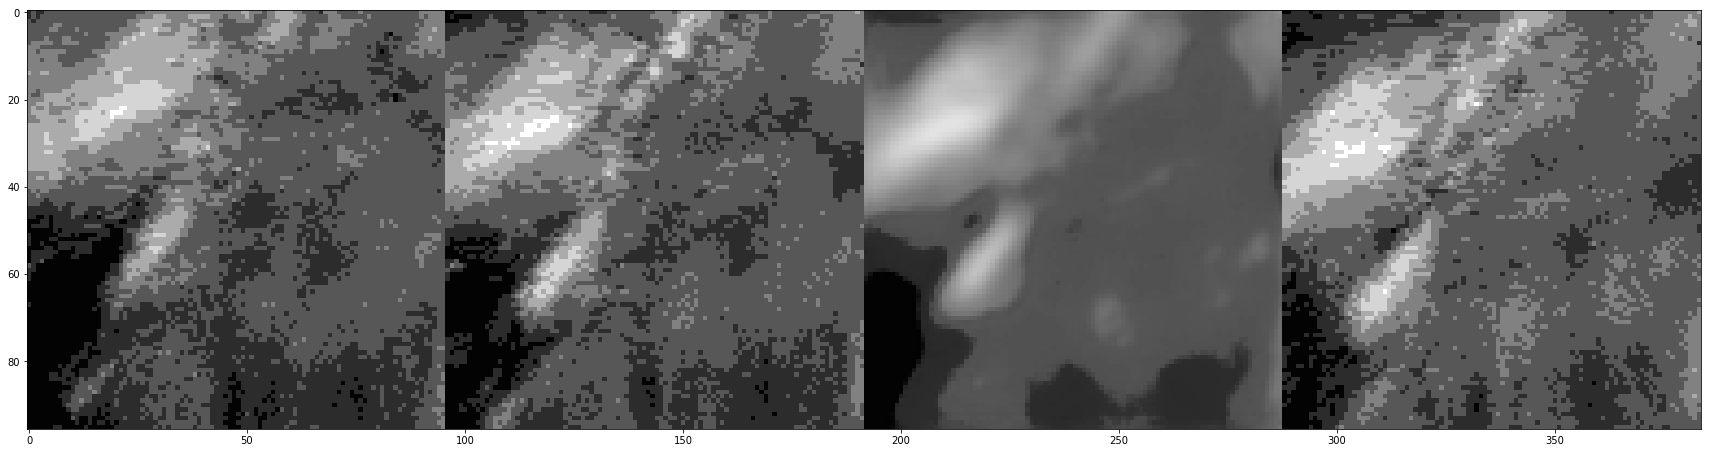

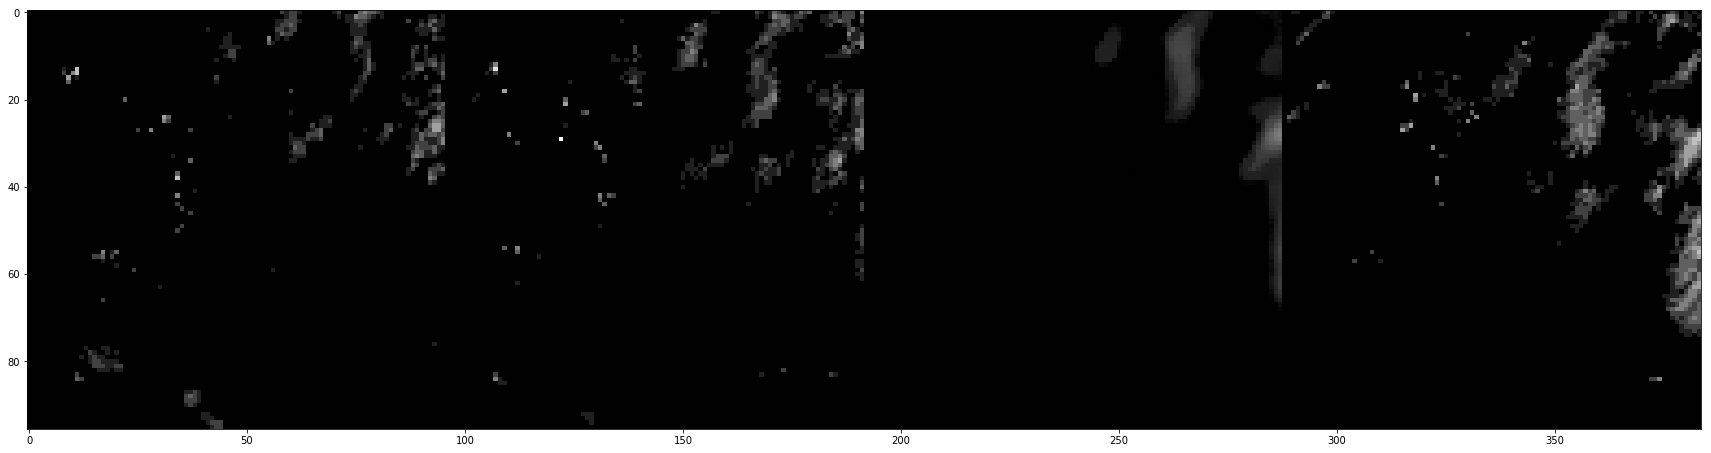

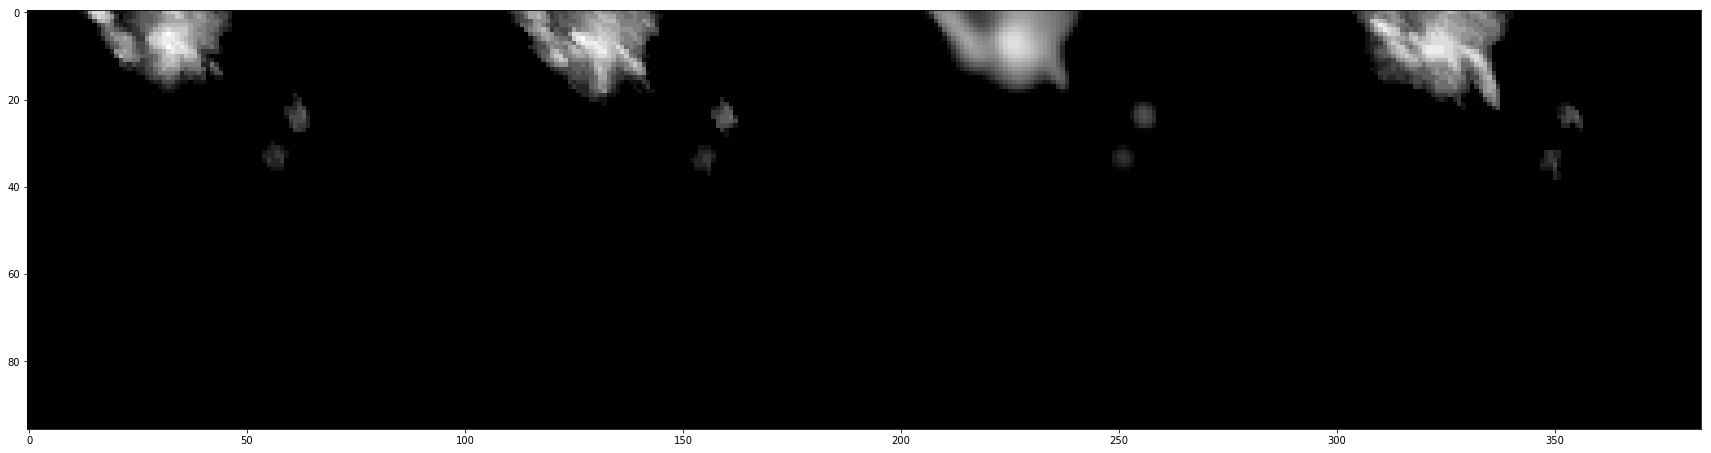

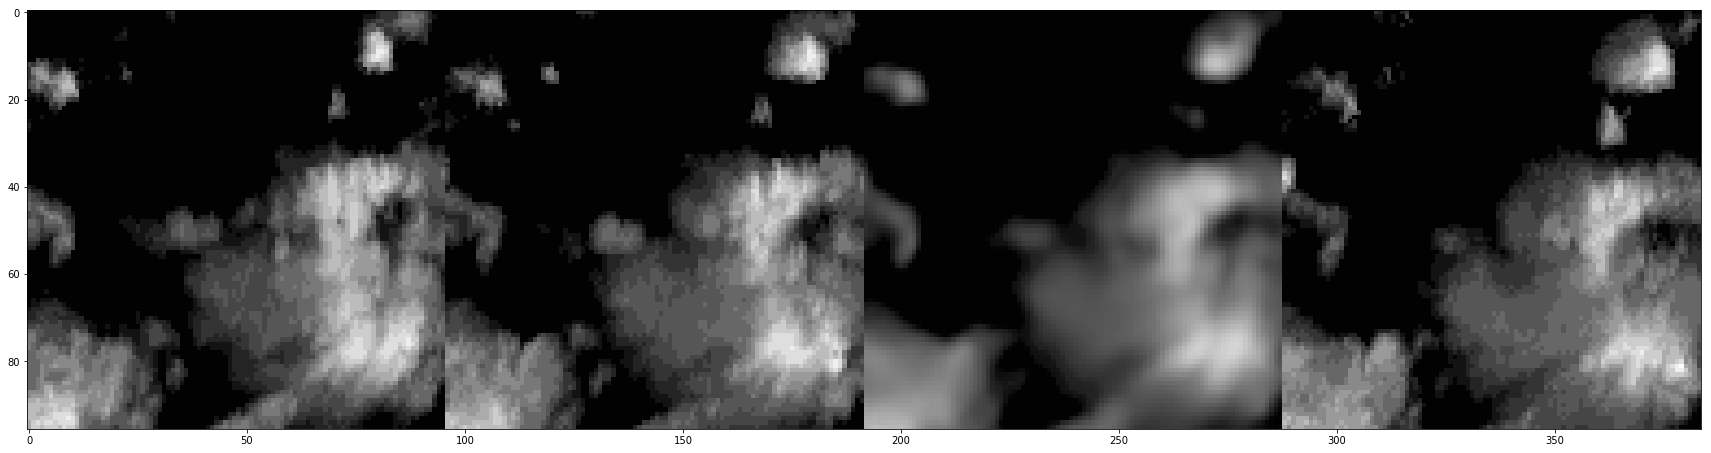

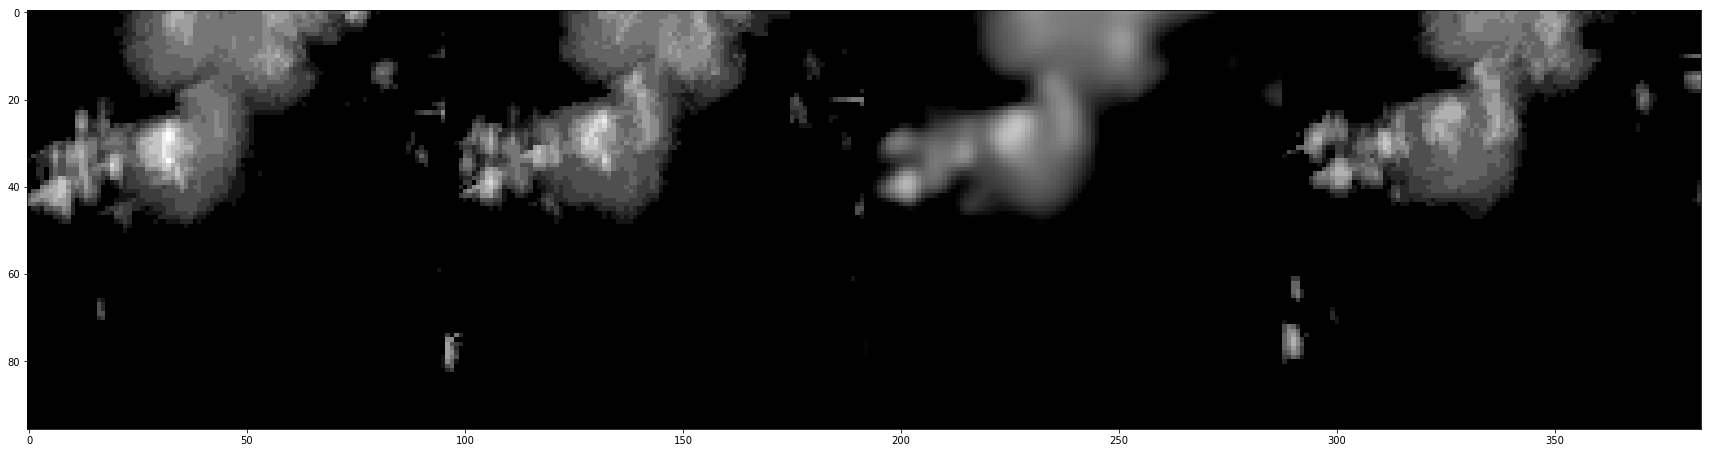

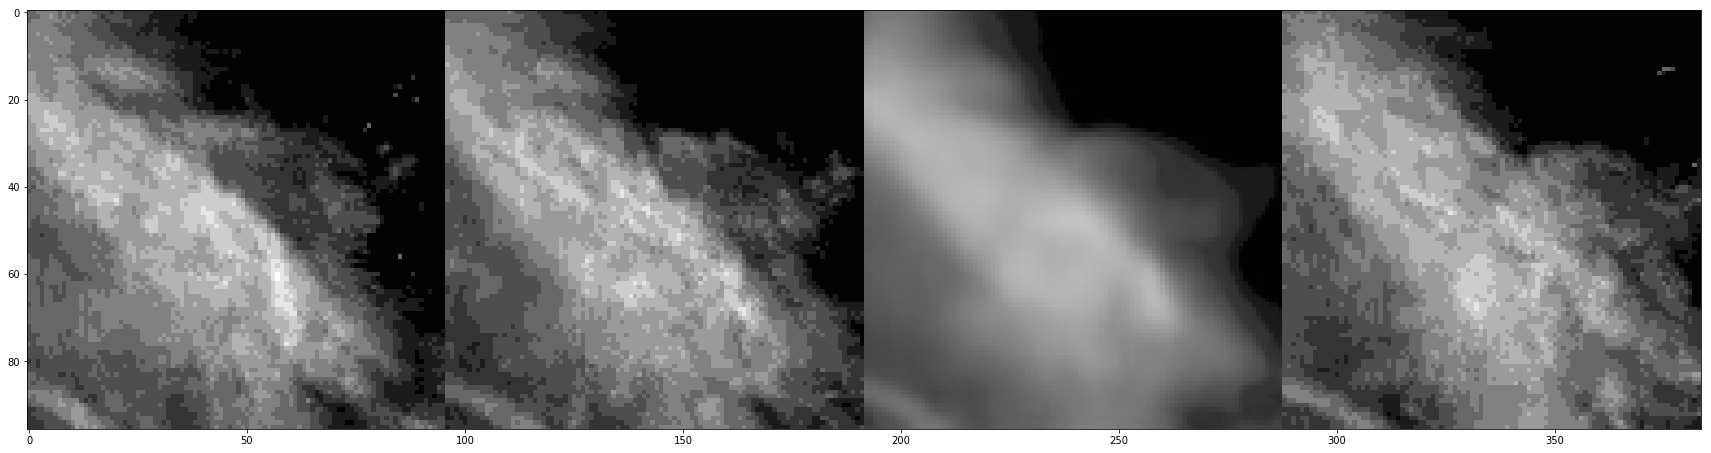

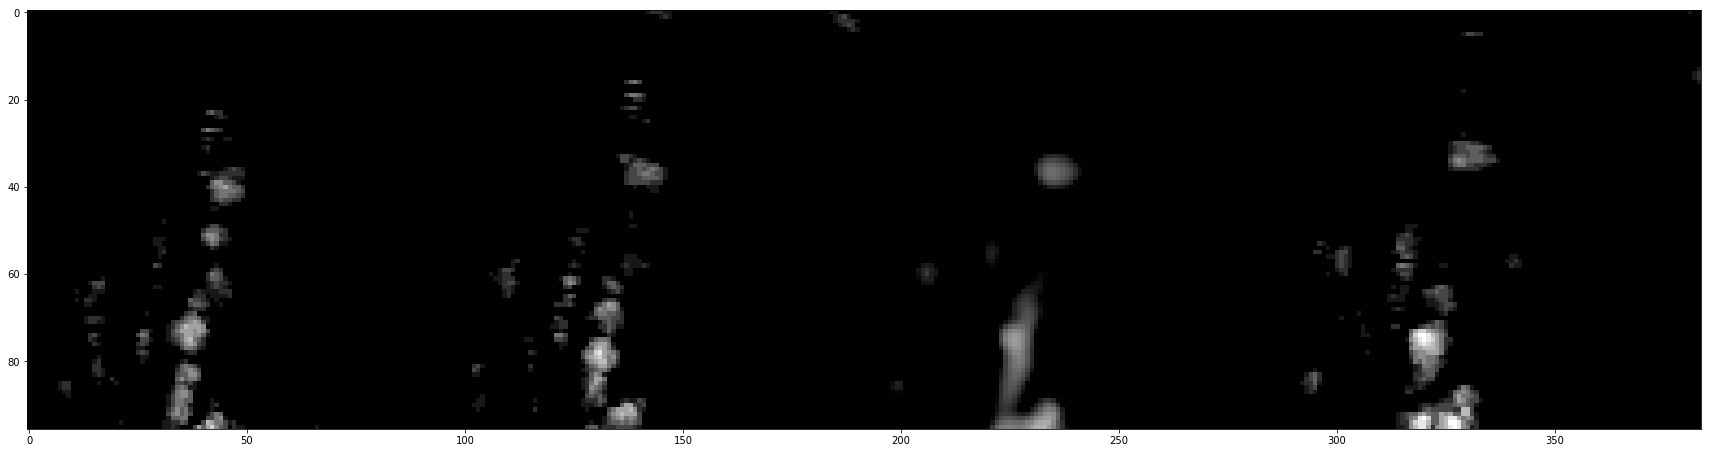

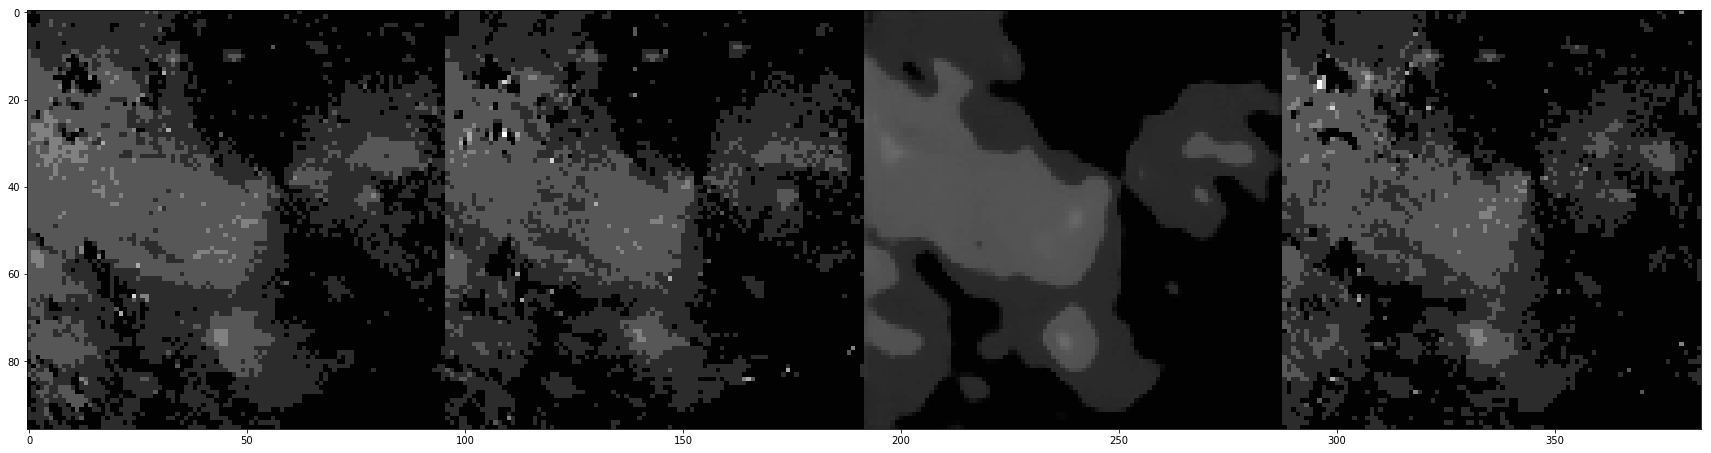

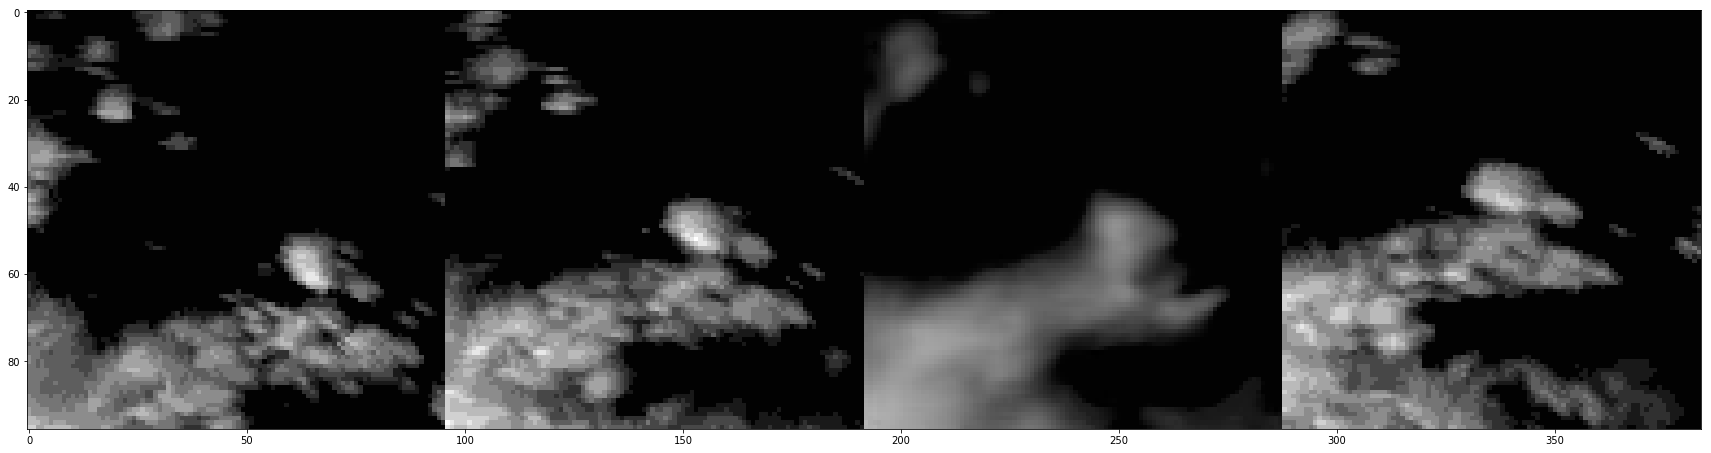

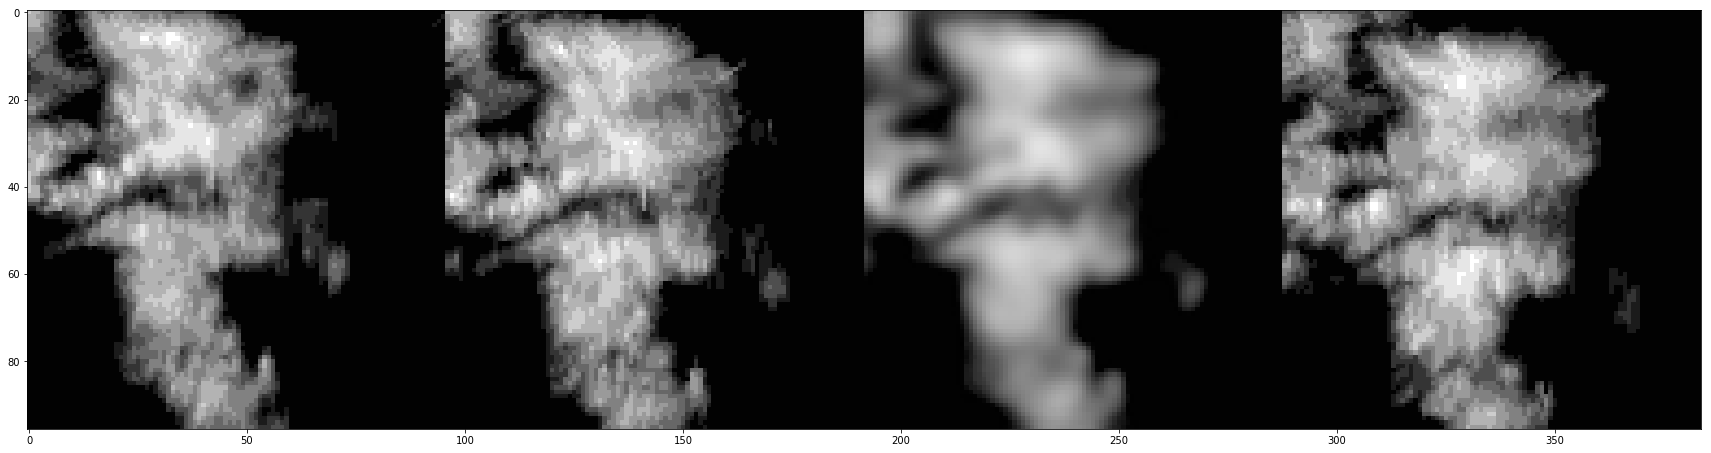

In [13]:
X_test, y_test = mt.loadData("",test=True,typeF='float16')
out = model( torch.tensor(X_test[0:10], dtype=torch.float).to(device) )
for i in range(10):
    mt.compare(i, X_test, y_test, out.cpu().detach().numpy(), folder="", channels_last=False)
    
X_test, y_test = [empty, empty]
gc.collect()

In [ ]:
torch.save(model.state_dict(), "weights")
# !cp weights gdrive/My\ Drive/weights3

In [ ]:
model.load_state_dict(torch.load("weights5"))

In [14]:
!zip fig.zip *.png
# !zip weights.zip weights*

updating: 00.png (deflated 3%)
updating: 01.png (stored 0%)
updating: 02.png (deflated 5%)
updating: 03.png (deflated 1%)
updating: 04.png (deflated 1%)
updating: 05.png (deflated 3%)
updating: 06.png (stored 0%)
updating: 07.png (deflated 2%)
updating: 08.png (deflated 2%)
updating: 09.png (deflated 2%)


In [ ]:
!cp fig.zip gdrive/My\ Drive/12/5_bilinear/.

In [ ]:
training.history = mt.fromCSV("history.csv")
training.history